### Feature extraction

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import os
from skimage.io import imread, imshow

def get_paths(directory):
    '''
    Devuelve la ruta relativa de las muestras .bmp
    '''
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bmp"):
                paths.append(os.path.join(root, file))
    return paths

In [77]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16 as vgg16_preprocessor
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications import MobileNetV2
import numpy as np
import cv2

model = VGG16(weights='imagenet') #include_top=False
model = Model(model.input, model.layers[-2].output)
# model.summary()

img_paths = get_paths("CASIA-Polar")
images = [cv2.resize(cv2.imread(muestra),(224,224))  for muestra in img_paths] # en blanco y negro
features = []

for img in images[:2]:
#     print(path)
#     img = image.load_img(path, target_size=(224, 224))
# for img in resized[:2]:
#     print(path)
    img_data = image.img_to_array(img)
    print(img_data.shape)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    print(vgg16_feature.shape)
    features.append(vgg16_feature)
print("DONE!")

(224, 224, 3)
(1, 4096)
(224, 224, 3)
(1, 4096)
DONE!


In [62]:
features[0][0].shape, features[0][0][:10]

((4096,), array([0.        , 0.        , 0.        , 1.51282   , 0.        ,
        0.        , 3.1035907 , 0.        , 0.16785401, 0.        ],
       dtype=float32))

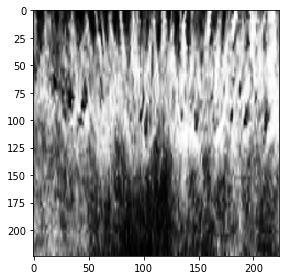

In [63]:
imshow(resized[0]);

--------------------------------

---------------------

In [88]:
# train_val_test = "CASIA-Classification"
# if os.path.exists(train_val_test):
#     shutil.rmtree(train_val_test)
# # os.mkdir(train_val_test)

In [66]:
# # directorio de entrenamiento
# train_dir = os.path.join(train_val_test, 'train')
# os.mkdir(train_dir)

# # directorio de validación
# val_dir = os.path.join(train_val_test, 'validation')
# os.mkdir(val_dir)

# # directorio de testeo
# test_dir = os.path.join(train_val_test, 'test')
# os.mkdir(test_dir)

In [72]:
# names = os.listdir("CASIA-Polar")
# # creamos los directorios con los nombres de los sujetos
# for n in names:
#     os.mkdir(os.path.join(train_dir,n))
#     os.mkdir(os.path.join(val_dir,n))
#     os.mkdir(os.path.join(test_dir,n))

Si fuese un problema de clasificación binaria únicamente habrían 2 clases, pero al tratarse de clasificación multiclase se necesitan más de 2 clases que en este caso se corresponden con el número de sujetos que tenemos en nuestra base de datos.

In [75]:
# sujetos = len(os.listdir(train_dir)) # nro de clases/sujetos
# # da igual listar el directorio de train, val o test, ya que los 3 tienen el mismo número de sujetos
# sujetos

108

Cada sujeto tiene 7 muestras, por lo que se destinarán 3 de esas muestras para el entrenamiento, 2 para validación y finalmente las 2 restantes para testear.

In [90]:
! pip install split-folders tqdm

In [101]:
# shutil.rmtree("CASIA-Classification")

In [102]:
import splitfolders
splitfolders.fixed("CASIA-Polar", output="CASIA-Classification", seed=1337, fixed=(2,2),group_prefix=None) # default values

Copying files: 756 files [00:00, 812.46 files/s]
